In [16]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
from scipy.integrate import dblquad
from sklearn.neighbors import KernelDensity
import time

from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import actionAngleAdiabatic
import numpy 

aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.45,c=True)
qdfS= quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aAS,cutcounter=True)

#Making qdf data from galpy
#initialize mean values for (R,z) in nat units.
mR,mz = 8.3/8.,0./8. 
vs= np.linspace(-1,2,100)
pvR= np.array([qdfS.pvR(v,mR,mz) for v in vs])
pvT= np.array([qdfS.pvT(v,mR,mz) for v in vs])
pvz= np.array([qdfS.pvz(v,mR,mz) for v in vs])

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert rectangular to cylindrical
R, phi, z = rect_to_cyl(samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vR, vT, vz = rect_to_cyl_vec(samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5], samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
samples_qdf = np.stack((R, phi, z, vR, vT, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (R)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (phi)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vR)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vT)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))
print(np.std(samples_qdf[:,0]), np.std(samples_qdf[:,1]), np.std(samples_qdf[:,2]), np.std(samples_qdf[:,3]), np.std(samples_qdf[:,4]), np.std(samples_qdf[:,5]))

C:\Users\micha\Anaconda3\lib\site-packages\galpy\df_src\quasiisothermaldf.py:266: RuntimeWarning: divide by zero encountered in log
  -kappa*jr*numpy.exp(-2.*lnsr)

#stars 1699708
min/max/mean (R) 7.80091199779 8.79962027735 8.29194098976
min/max/mean (phi) 3.08134693839 3.20183526017 3.14130030289
min/max/mean (z) -0.472240992289 0.525186432321 0.0205541620714
min/max/mean (vR) -226.541732449 236.497052579 0.00739381590152
min/max/mean (vT) 18.0377131063 300.644001151 200.9257125
min/max/mean (vz) -78.6318475051 79.4952977672 -0.00151810605736
0.19569240168 0.024711492153 0.16310598222 44.5400796638 32.3019489683 18.9869492162


In [6]:
def generate_KDE(bwc, inputs, ker):
    
    #Scaling velocities with z-score
    inputs_std = np.nanstd(inputs, axis=0)
    i1, i2, i3, i4, i5, i6 = np.mean(inputs, axis=0)
    inputs_mean = np.hstack((i1, i2, i3, i4, i5, i6))
    inputs = (inputs - inputs_mean)/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Multivariate Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    bw = bwc * np.nanstd(inputs) * N ** (-1/10.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        
        #Scaling samples with standard deviation
        samples = (samples - inputs_mean)/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [7]:
#Generate kde for 6D qdf inputs
kde_qdf_epanechnikov = generate_KDE(5, samples_qdf, 'epanechnikov')


In [43]:
start_overall = time.time()
min_bw = 4.
max_bw = 6.
step = 0.2
bw_options = np.arange(min_bw, max_bw + step, step)
dens = np.ones((3, 16, 100))

for bw in bw_options:
    start = time.time()
    print("Now integrating with KDE bandwidth =", bw)
    kde_qdf_epanechnikov = generate_KDE(bw, samples_qdf, 'epanechnikov')
               
    #input values for velocities (vR, vT, vz)
    v_input = np.linspace(-200, 400, 100)

    # -----------------
    # Integrate over vR
    # -----------------

    def kde_qdf_cyl_vR(vT, vz, R, phi, z, vR):
        evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
        return evaluation

    def integrate_over_vR(kde_qdf_epanechnikov, vR): #bounds of vT = [0, 300], bounds of vz = [-100, 100]
        return dblquad(kde_qdf_cyl_vR, 0, 300, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.01)  # args=(R, phi, z, vR)

    print("In progress: KDE Evaluations along vR from [-200, 400] over 100 subintervals.")

    counter = 0
    for v in np.nditer(v_input):
        dens[0][int((bw-min_bw)/step)][counter], error = integrate_over_vR(kde_qdf_epanechnikov, v)
        counter += 1

    # -----------------
    # Integrate over vT
    # -----------------

    def kde_qdf_cyl_vT(vR, vz, R, phi, z, vT):
        evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
        return evaluation

    def integrate_over_vT(kde_qdf_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
        return dblquad(kde_qdf_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.1)  # args=(R, phi, z, vR)

    print("In progress: KDE Evaluations along vT from [-200, 400] over 100 subintervals.")

    counter = 0
    for v in np.nditer(v_input):
        dens[1][int((bw-min_bw)/step)][counter], error = integrate_over_vT(kde_qdf_epanechnikov, v)
        counter += 1
               
    # -----------------
    # Integrate over vz
    # -----------------

    def kde_qdf_cyl_vz(vR, vT, R, phi, z, vz):
        evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
        return evaluation

    def integrate_over_vz(kde_qdf_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [0, 300]
        return dblquad(kde_qdf_cyl_vz, -100, 100, 0, 300, args=([8.3, 3.14, 0., vz]), epsabs=0.01)  # args=(R, phi, z, vR)

    print("In Progress: KDE Evaluations along vz from [-200, 400] over 100 subintervals.")

    counter = 0
    for v in np.nditer(v_input): 
        dens[2][int((bw-min_bw)/step)][counter], error = integrate_over_vz(kde_qdf_epanechnikov, v)
        counter += 1
        
    end = time.time()           
    print("Time to integrate at bandwidth = ", bw, " is: "'{}'" min".format(round((end - start)/60, 2)))
    print()
    
end = time.time()
print("Total time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))



Now integrating with KDE bandwidth = 4.0
In progress: KDE Evaluations along vR from [-200, 400] over 100 subintervals.
In progress: KDE Evaluations along vT from [-200, 400] over 100 subintervals.
In Progress: KDE Evaluations along vz from [-200, 400] over 100 subintervals.
Time to integrate at bandwidth =  4.0  is: 8.9 min

Now integrating with KDE bandwidth = 4.2
In progress: KDE Evaluations along vR from [-200, 400] over 100 subintervals.
In progress: KDE Evaluations along vT from [-200, 400] over 100 subintervals.
In Progress: KDE Evaluations along vz from [-200, 400] over 100 subintervals.
Time to integrate at bandwidth =  4.2  is: 8.07 min

Now integrating with KDE bandwidth = 4.4
In progress: KDE Evaluations along vR from [-200, 400] over 100 subintervals.
In progress: KDE Evaluations along vT from [-200, 400] over 100 subintervals.
In Progress: KDE Evaluations along vz from [-200, 400] over 100 subintervals.
Time to integrate at bandwidth =  4.4  is: 7.97 min

Now integrating w

At Bandwidth = 4.0


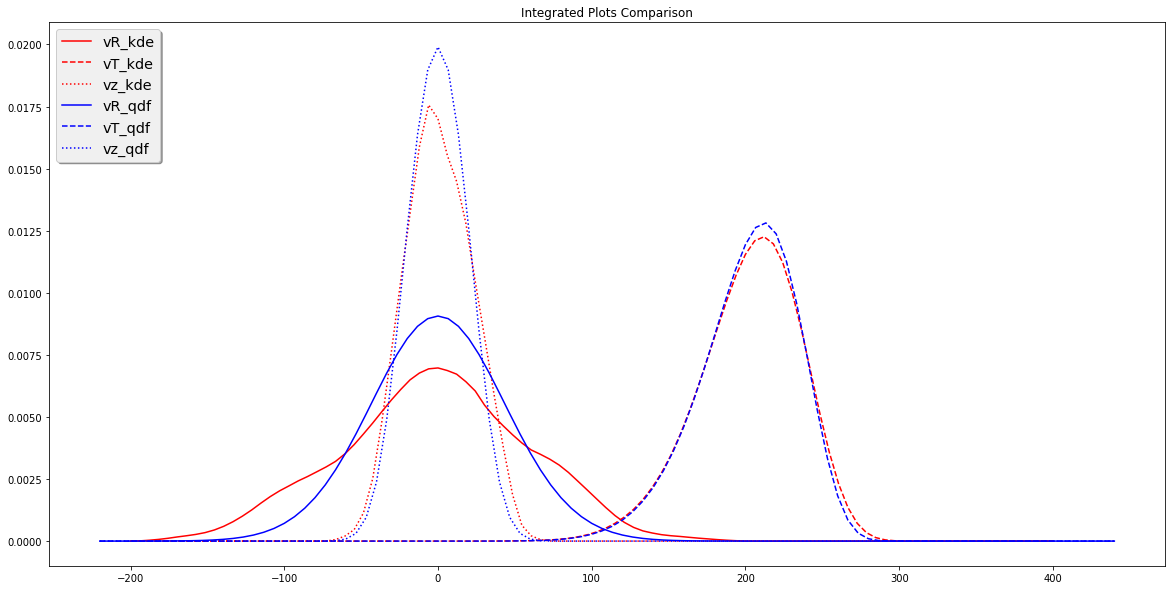

At Bandwidth = 4.2


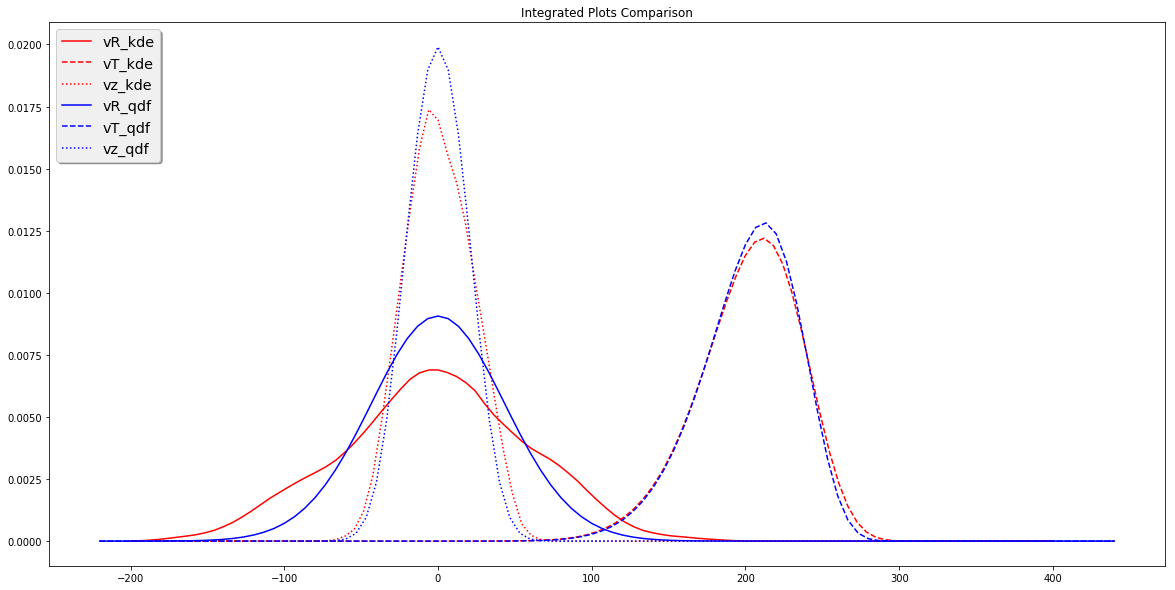

At Bandwidth = 4.4


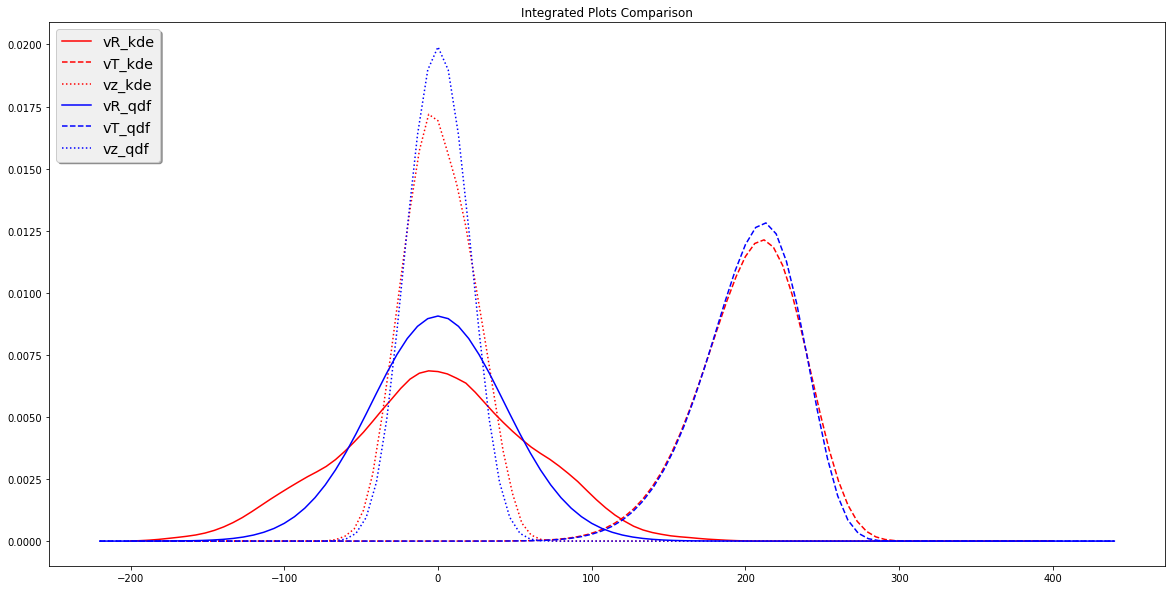

At Bandwidth = 4.6


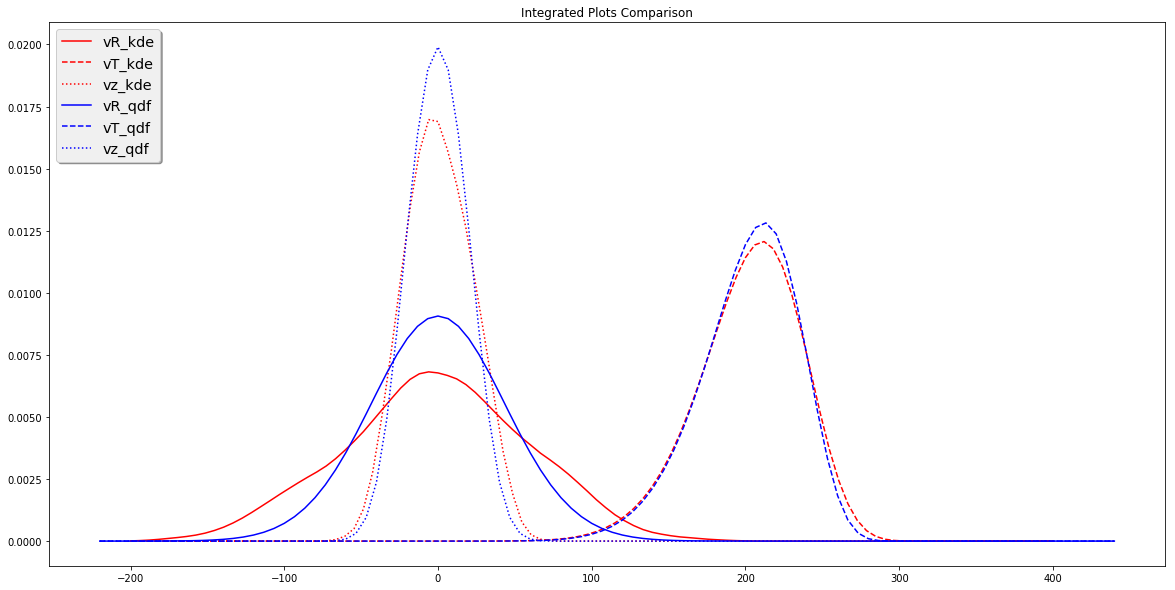

At Bandwidth = 4.8


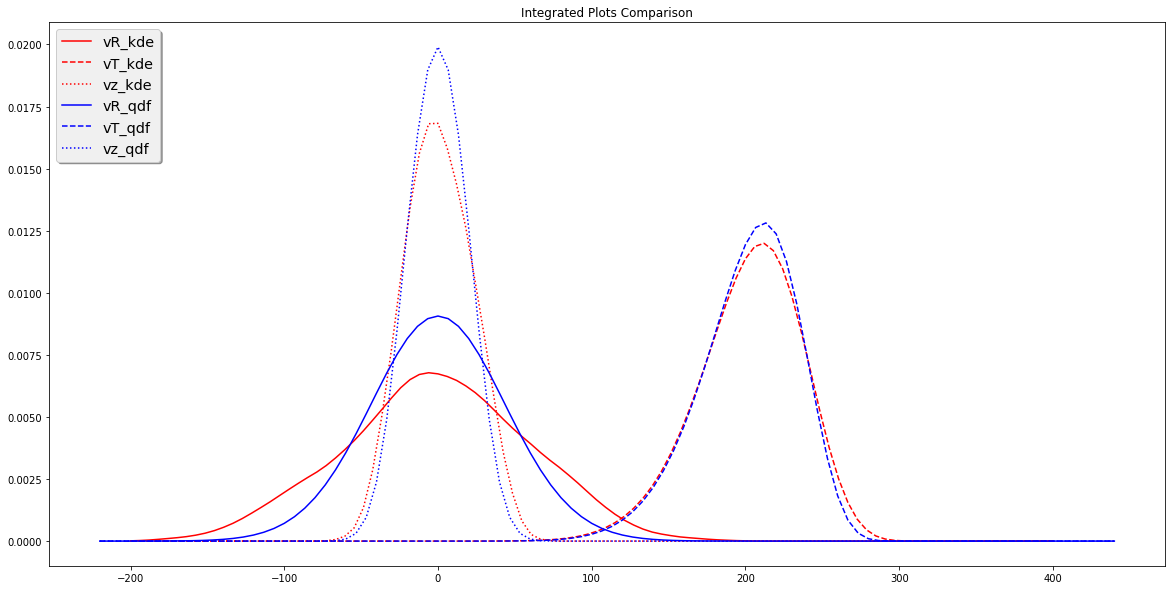

At Bandwidth = 5.0


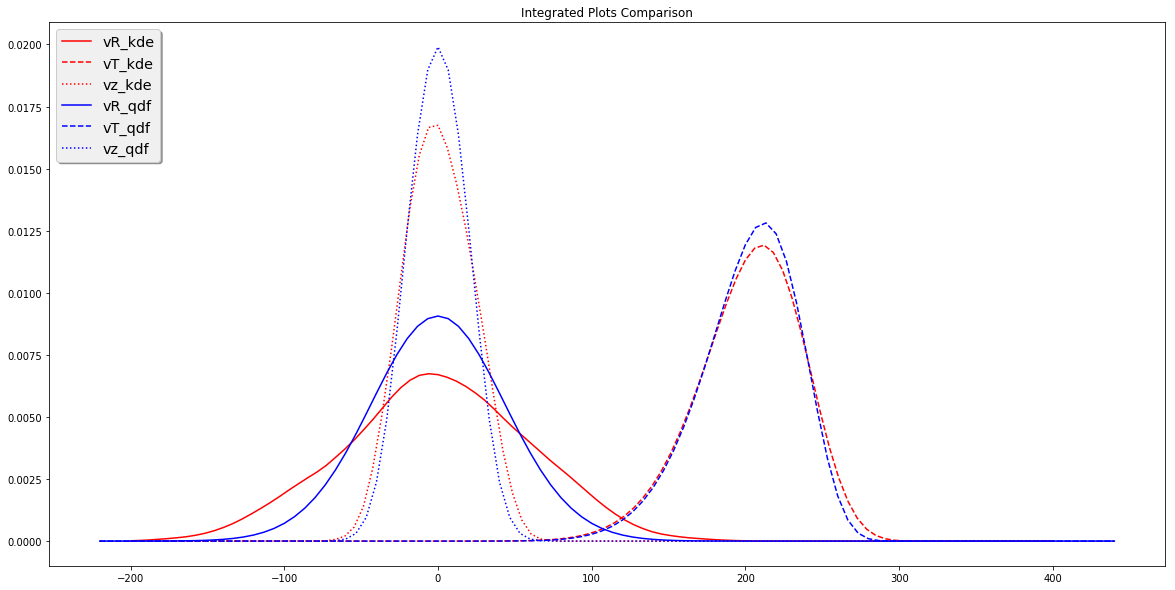

At Bandwidth = 5.2


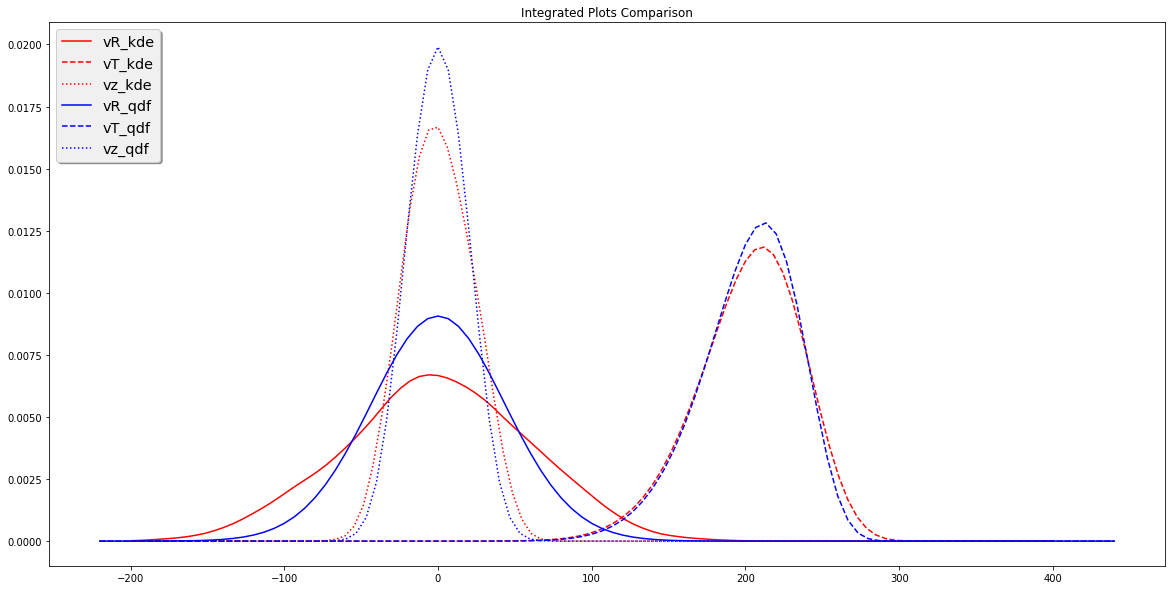

At Bandwidth = 5.4


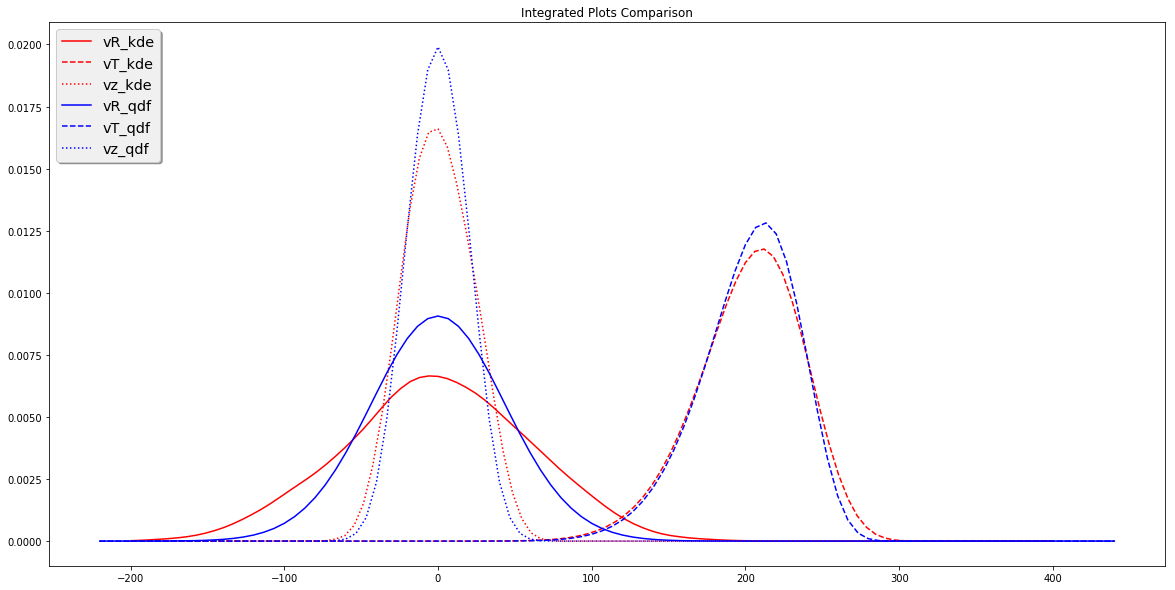

At Bandwidth = 5.6


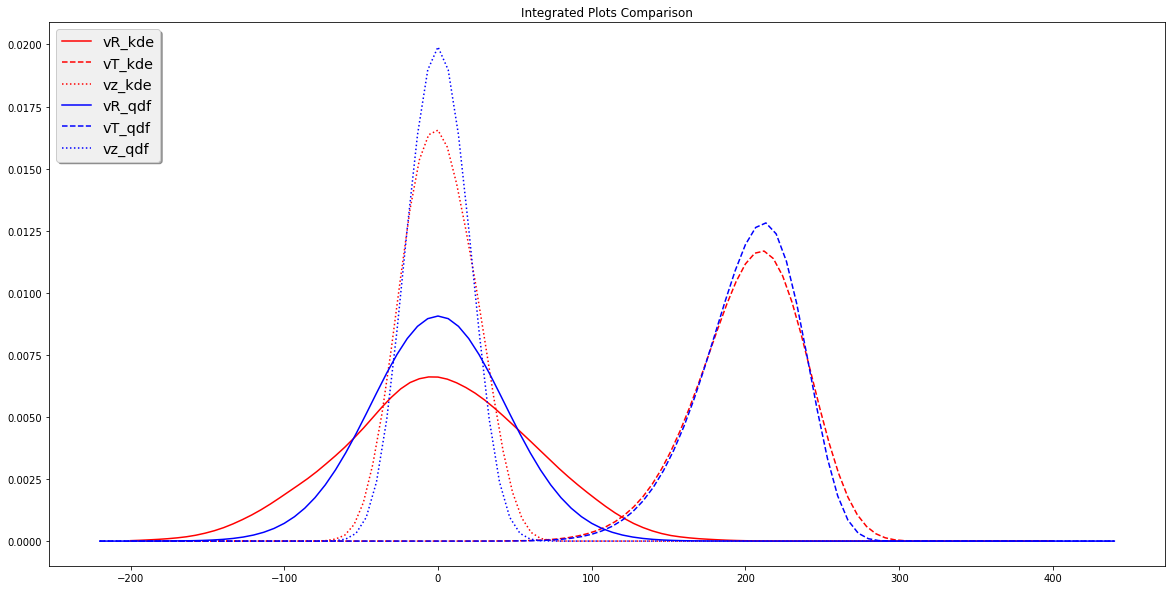

At Bandwidth = 5.8


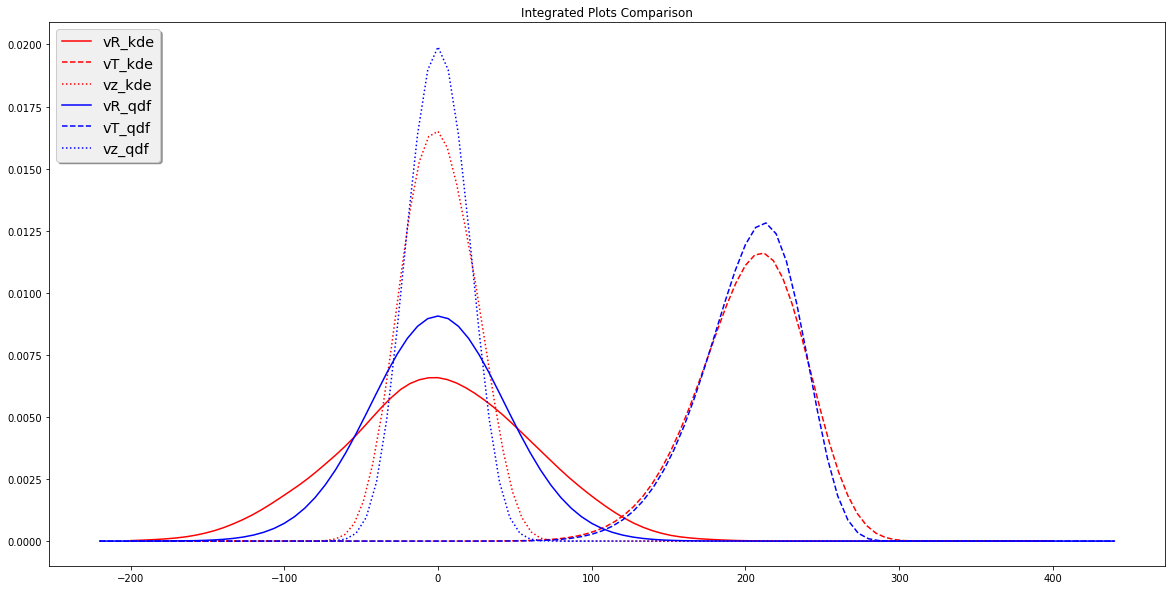

At Bandwidth = 6.0


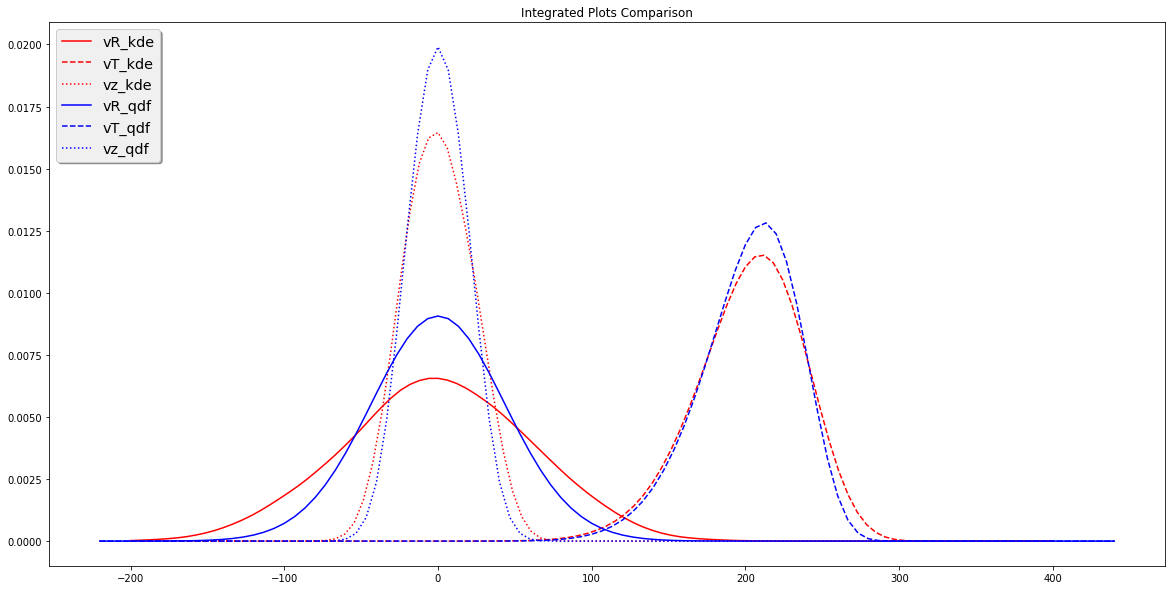

In [45]:
for bw in bw_options:
    # overplotting qdf and kde integrated
    fig, ax = plt.subplots(figsize=(20, 10))
    
    print("At Bandwidth =", bw)
    ax.set_title('Integrated Plots Comparison')
    ax.plot(v_input, dens[0][int((bw-min_bw)/step)]/np.sum(dens[0][int((bw-min_bw)/step)])/(v_input[1]-v_input[0]), 'r', label='vR_kde') #normalized area to 1
    ax.plot(v_input, dens[1][int((bw-min_bw)/step)]/np.sum(dens[1][int((bw-min_bw)/step)])/(v_input[1]-v_input[0]), 'r--', label='vT_kde')
    ax.plot(v_input, dens[2][int((bw-min_bw)/step)]/np.sum(dens[2][int((bw-min_bw)/step)])/(v_input[1]-v_input[0]), 'r:', label='vz_kde')
    ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, 'b', label='vR_qdf')
    ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, 'b--', label='vT_qdf')
    ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, 'b:', label='vz_qdf')
    legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    legend.get_frame().set_facecolor('#F0F0F0')
    plt.show()